In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [ ]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-05-23 04:50:07--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-05-23 04:50:07--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.03s   

2025-05-23 04:50:08 (4.14 MB/s) - ‘s

In [ ]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
for row in cursor.fetchall():
    print(row[0])

CREATE TABLE checkpoints (
                thread_id TEXT NOT NULL,
                checkpoint_ns TEXT NOT NULL DEFAULT '',
                checkpoint_id TEXT NOT NULL,
                parent_checkpoint_id TEXT,
                type TEXT,
                checkpoint BLOB,
                metadata BLOB,
                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id)
            )
CREATE TABLE writes (
                thread_id TEXT NOT NULL,
                checkpoint_ns TEXT NOT NULL DEFAULT '',
                checkpoint_id TEXT NOT NULL,
                task_id TEXT NOT NULL,
                idx INTEGER NOT NULL,
                channel TEXT NOT NULL,
                type TEXT,
                value BLOB,
                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id, task_id, idx)
            )


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState
from typing import Literal

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

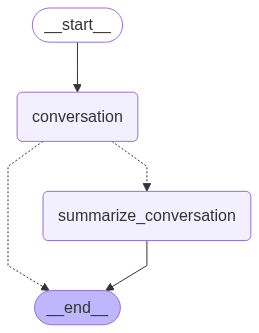

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's great to hear from you again. If there's anything specific you'd like to discuss about the 49ers or any other topic, feel free to let me know!
================================== Ai Message ==================================

Your name is Lance! If there's anything else you'd like to talk about or ask, just let me know.
================================== Ai Message ==================================

That's awesome, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that stands out to you?


In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='21b17f07-792a-4fbc-8219-3ce9c06a5ecd'), AIMessage(content="Hi Lance! It's great to hear from you again. If there's anything specific you'd like to discuss about the 49ers or any other topic, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 337, 'total_tokens': 373, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BaGJZeyswjRpUaVwmxxW6gu7HfMw6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--76733f7b-f7d0-4f67-a948-786ef35852ab-0', usage_metadata={'input_tokens': 337, 'output_tokens': 36, 'total_tokens